### Mount Google Drive to Google Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls  "/content/drive/My Drive/nss_data_science/Colab Notebooks/dq8_biggexpress/dq8_data"

DataInfo.docx	 ServiceFaultCodes.xlsx
J1939Faults.csv  VehicleDiagnosticOnboardData.csv


### Import packages

In [5]:
!pip install geopandas

     |████████████████████████████████| 931kB 1.4MB/s 
     |████████████████████████████████| 14.7MB 50.9MB/s 
     |████████████████████████████████| 10.4MB 48.6MB/s 


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)
import shapely
import geopandas as gpd
from datetime import datetime

### Data Description

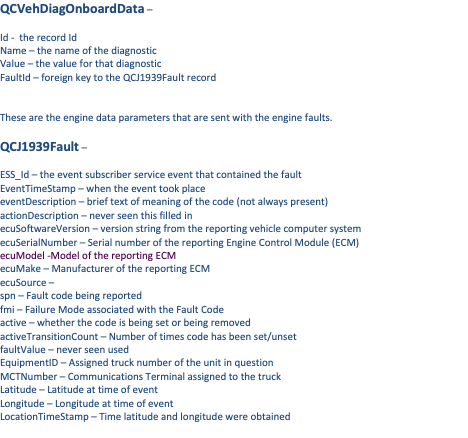

### Data Preprocessing


### Dataset: QCJ1939Fault

In [7]:
j1939 = pd.read_csv('/content/drive/My Drive/nss_data_science/Colab Notebooks/dq8_biggexpress/dq8_data/J1939Faults.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
j1939.head()

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp
0,1,990349,2015-02-21 10:47:13.000,Low (Severity Low) Engine Coolant Level,NaN,unknown,unknown,unknown,unknown,0,111,17,True,2,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:34:25.000
1,2,990360,2015-02-21 11:34:34.000,NaN,NaN,unknown,unknown,unknown,unknown,11,629,12,True,127,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:35:10.000
2,3,990364,2015-02-21 11:35:31.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,False,127,NaN,1369,105336226,41.421250,-87.767361,2015-02-21 11:35:26.000
3,4,990370,2015-02-21 11:35:33.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,True,127,NaN,1369,105336226,41.421018,-87.767361,2015-02-21 11:36:08.000
4,5,990416,2015-02-21 11:39:41.000,NaN,NaN,22281684P01*22357957P01*22362082P01*,13063430,0USA13_13_0415_2238A,VOLVO,0,4364,17,False,2,NaN,1674,105427130,38.416481,-89.442638,2015-02-21 11:39:37.000


In [9]:
j1939.tail()

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp
1187330,1248454,123904424,2020-03-06 14:00:26.000,Low (Severity Low) Catalyst Tank Level,NaN,04384413*22383729*082218154102*60701732*G1*BGT*,80156139,6X1u17D1500000000,CMMNS,0,1761,17,False,3,NaN,2282,105439740,37.094768,-85.897407,2020-03-06 14:00:21.000
1187331,1248455,123905139,2020-03-06 14:04:23.000,Condition Exists Engine Protection Torque Derate,NaN,04358814*06099720*030816202706*09400153*G1*BDR*,79932020,6X1u13D1500000000,CMMNS,0,1569,31,True,5,NaN,1994,105354084,34.390740,-79.461805,2020-03-06 14:04:59.000
1187332,1248456,123905996,2020-03-06 14:13:38.000,Abnormal Rate of Change Aftertreatment 1 Intak...,NaN,05317106*05100987*050719120655*09401585*G1*BDR*,79880653,6X1u13D1500000000,CMMNS,0,3216,10,True,1,NaN,1850,105336308,34.430370,-84.920509,2020-03-06 14:14:14.000
1187333,1248457,123906113,2020-03-06 14:14:13.000,Low (Severity Medium) Engine Coolant Level,NaN,04384413*22544852*090619141107*60701756*G1*BGT*,NaN,NaN,NaN,0,111,18,True,8,NaN,2377,108605700,35.030925,-85.321527,2020-03-06 14:14:49.000
1187334,1248458,123906131,2020-03-06 14:15:34.000,Low (Severity Medium) Engine Coolant Level,NaN,04384413*22544852*090619141107*60701756*G1*BGT*,NaN,NaN,NaN,0,111,18,False,8,NaN,2377,108605700,35.027314,-85.323472,2020-03-06 14:15:30.000


In [10]:
j1939.shape

(1187335, 20)

In [0]:
#drop unused columns
j1939 = j1939.drop(columns = ['MCTNumber','ESS_Id', 'eventDescription','actionDescription','faultValue','ecuSource','ecuSoftwareVersion',
                    'ecuSerialNumber','ecuModel','ecuMake','LocationTimeStamp','activeTransitionCount'])

In [0]:
#change datatype for timestamp
j1939['EventTimeStamp'] = pd.to_datetime(j1939['EventTimeStamp'], format='%Y-%m-%d %H:%M:%S.%f')

In [13]:
j1939.shape

(1187335, 8)

In [14]:
j1939.dtypes

RecordID                   int64
EventTimeStamp    datetime64[ns]
spn                        int64
fmi                        int64
active                      bool
EquipmentID               object
Latitude                 float64
Longitude                float64
dtype: object

3 service locations to remove: 

193 Aldi Blvd, Mt Juliet, TN: 36.0666667, -86.4347222

137 Eady Road – Bell Buckle, TN: 35.5883333, -86.4438888

5754 Fish Hatchery Road – Russellville, TN: 36.1950, -83.174722

In [0]:
#create a Polygon using surrounding points found in Google Maps
from shapely.geometry import Point, Polygon
#Aldi Blvd polygon
aldi_coords = [(-86.454413, 36.077043),
               (-86.409545, 36.076150),
               (-86.409760, 36.057174),
               (-86.456580, 36.056203)]
aldi_poly = Polygon(aldi_coords)
#Eady Rd polygon
eady_coords = [(-86.451845, 35.592803),
               (-86.434829, 35.592209),
               (-86.450342, 35.582106),
               (-86.435322, 35.582158)]
eady_poly = Polygon(eady_coords)
#Fish Hatchery Rd polygon
fish_coords = [(-83.183176, 36.200329),
               (-83.166332, 36.199896),
               (-83.181696, 36.189818),
               (-83.166740, 36.189956)]
fish_poly = Polygon(fish_coords)

In [16]:
# Create geometry column with long,lat as points
geometry = [Point(xy) for xy in zip(j1939['Longitude'], j1939['Latitude'])]
crs = {'init': 'epsg:4326'}
j1939 = gpd.GeoDataFrame(j1939, crs=crs,geometry=geometry)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [17]:
#testing `.within` and `.contains` for points 
# would like to make function to pass geometry and make new column
p1 = Point(-84.626851, 38.857638)
p1.within(aldi_poly)
aldi_poly.contains(p1)

False

In [0]:
def polygon_contains(point):
  if aldi_poly.contains(point):
    return ("in")
  elif eady_poly.contains(point):
    return ("in")
  elif fish_poly.contains(point):
    return ("in")
  else:
   return ("out")

In [0]:
j1939['polygon_contains'] = j1939['geometry'].apply(polygon_contains)

In [20]:
j1939.head()

,RecordID,EventTimeStamp,spn,fmi,active,EquipmentID,Latitude,Longitude,geometry,polygon_contains
0,1,2015-02-21 10:47:13,111,17,True,1439,38.857638,-84.626851,POINT (-84.62685 38.85764),out
1,2,2015-02-21 11:34:34,629,12,True,1439,38.857638,-84.626851,POINT (-84.62685 38.85764),out
2,3,2015-02-21 11:35:31,1807,2,False,1369,41.421250,-87.767361,POINT (-87.76736 41.42125),out
3,4,2015-02-21 11:35:33,1807,2,True,1369,41.421018,-87.767361,POINT (-87.76736 41.42102),out
4,5,2015-02-21 11:39:41,4364,17,False,1674,38.416481,-89.442638,POINT (-89.44264 38.41648),out


In [21]:
#identifying number of locations/coordinates in and out of service location polygons
j1939['polygon_contains'].value_counts()

out    1082033
in      105302
Name: polygon_contains, dtype: int64

In [0]:
#dropping rows with locations/coordinates in service location polygons
j1939.drop(j1939[j1939['polygon_contains'] == 'in'].index, inplace=True)

In [23]:
#identifying number after dropping rows
j1939['polygon_contains'].value_counts()

out    1082033
Name: polygon_contains, dtype: int64

In [24]:
j1939.shape

(1082033, 10)

In [0]:
j1939 = j1939.drop(columns = ['Latitude','Longitude','geometry','polygon_contains'])

In [0]:
#dropping rows with active=false
j1939.drop(j1939[j1939['active'] == False].index, inplace=True)

In [27]:
j1939.shape

(560227, 6)

In [53]:
j1939.head()

,RecordID,EventTimeStamp,spn,fmi,active,EquipmentID,spn_fmi,spn_fmi_values
0,1,2015-02-21 10:47:13,111,17,True,1439,111_17,111_17
1,2,2015-02-21 11:34:34,629,12,True,1439,629_12,629_12
3,4,2015-02-21 11:35:33,1807,2,True,1369,1807_2,1807_2
5,6,2015-02-21 11:40:22,111,17,True,1417,111_17,111_17
6,7,2015-02-21 11:40:52,111,17,True,1597,111_17,111_17


In [0]:
j1939['5246'] = j1939['spn'].apply(lambda x: 1 if x == 5246 else 0)

In [0]:
j1939['5246_timestamp'] = j1939.loc[j1939['5246'] == 1, 'EventTimeStamp']

In [112]:
j1939[j1939['5246'] == 1]

,RecordID,EventTimeStamp,spn,fmi,active,EquipmentID,spn_fmi,spn_fmi_values,spn_5246,5246,5246_timestamp
2089,2090,2015-02-23 05:05:44,5246,0,True,1630,5246_0,5246_0,1,1,2015-02-23 05:05:44
2971,2972,2015-02-23 15:54:22,5246,0,True,1487,5246_0,5246_0,1,1,2015-02-23 15:54:22
5713,5714,2015-02-25 13:53:08,5246,0,True,1329,5246_0,5246_0,1,1,2015-02-25 13:53:08
6534,6535,2015-02-26 22:24:29,5246,0,True,1419,5246_0,5246_0,1,1,2015-02-26 22:24:29
6628,6629,2015-02-27 09:09:56,5246,0,True,1486,5246_0,5246_0,1,1,2015-02-27 09:09:56
...,...,...,...,...,...,...,...,...,...,...,...
1177700,1237841,2011-01-01 00:03:23,5246,0,True,2175,5246_0,5246_0,1,1,2011-01-01 00:03:23
1178571,1238712,2020-02-03 15:46:46,5246,16,True,2211,5246_16,5246_16,1,1,2020-02-03 15:46:46
1179414,1239555,2020-02-06 07:45:08,5246,0,True,1854,5246_0,5246_0,1,1,2020-02-06 07:45:08
1181700,1241841,2020-02-13 13:32:39,5246,0,True,1872,5246_0,5246_0,1,1,2020-02-13 13:32:39


In [108]:
j1939['5246_timestamp'] = pd.to_datetime(j1939['5246_timestamp'], format='%Y-%m-%d %H:%M:%S.%f')

ValueError: ignored

In [93]:
j1939['5246_timestamp'] = j1939['spn'].apply(spn_5246)

KeyboardInterrupt: ignored

### Dataset: Service Fault Codes

In [0]:
service_fault = pd.read_excel('/content/drive/My Drive/nss_data_science/Colab Notebooks/dq8_biggexpress/dq8_data/ServiceFaultCodes.xlsx')

In [29]:
service_fault.head()

,Published in CES 14602,Cummins Fault Code,Revision,PID,SID,MID,J1587 FMI,SPN,J1939 FMI,J2012 Pcode,Lamp Color,Lamp Device,Cummins Description,Algorithm Description
0,Y,111,167,Not Mapped,254,0,12,629,12,P0606,Red,Stop / Shutdown,Engine Control Module Critical Internal Failur...,Error internal to the ECM related to memory ha...
1,Y,112,167,Not Mapped,20,128,7,635,7,Not Mapped,Red,Stop / Shutdown,Engine Timing Actuator Driver Circuit - Mechan...,Mechanical failure in the engine timing actuat...
2,Y,113,167,Not Mapped,20,128,3,635,3,Not Mapped,Amber,Warning,Engine Timing Actuator Driver Circuit - Voltag...,High signal voltage detected at the engine tim...
3,Y,114,167,Not Mapped,20,128,4,635,4,Not Mapped,Amber,Warning,Engine Timing Actuator Driver Circuit - Voltag...,Low voltage detected at the engine timing actu...
4,Y,115,167,190,Not Mapped,Not Mapped,2,612,2,P0008,Red,Stop / Shutdown,Engine Magnetic Speed/Position Lost Both of Tw...,The ECM has detected that the primary and back...


In [30]:
service_fault = service_fault.replace('Not Mapped', np.nan)
service_fault.head()

,Published in CES 14602,Cummins Fault Code,Revision,PID,SID,MID,J1587 FMI,SPN,J1939 FMI,J2012 Pcode,Lamp Color,Lamp Device,Cummins Description,Algorithm Description
0,Y,111,167,NaN,254,0,12,629,12,P0606,Red,Stop / Shutdown,Engine Control Module Critical Internal Failur...,Error internal to the ECM related to memory ha...
1,Y,112,167,NaN,20,128,7,635,7,NaN,Red,Stop / Shutdown,Engine Timing Actuator Driver Circuit - Mechan...,Mechanical failure in the engine timing actuat...
2,Y,113,167,NaN,20,128,3,635,3,NaN,Amber,Warning,Engine Timing Actuator Driver Circuit - Voltag...,High signal voltage detected at the engine tim...
3,Y,114,167,NaN,20,128,4,635,4,NaN,Amber,Warning,Engine Timing Actuator Driver Circuit - Voltag...,Low voltage detected at the engine timing actu...
4,Y,115,167,190,NaN,NaN,2,612,2,P0008,Red,Stop / Shutdown,Engine Magnetic Speed/Position Lost Both of Tw...,The ECM has detected that the primary and back...


In [31]:
service_fault.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7124 entries, 0 to 7123
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Published in CES 14602  7124 non-null   object
 1   Cummins Fault Code      7124 non-null   int64 
 2   Revision                7124 non-null   int64 
 3   PID                     369 non-null    object
 4   SID                     1613 non-null   object
 5   MID                     1613 non-null   object
 6   J1587 FMI               7124 non-null   int64 
 7   SPN                     7124 non-null   int64 
 8   J1939 FMI               7124 non-null   int64 
 9   J2012 Pcode             727 non-null    object
 10  Lamp Color              7124 non-null   object
 11  Lamp Device             7124 non-null   object
 12  Cummins Description     7124 non-null   object
 13  Algorithm Description   2005 non-null   object
dtypes: int64(5), object(9)
memory usage: 779.3+ KB


In [32]:
service_fault.isnull().sum()

Published in CES 14602       0
Cummins Fault Code           0
Revision                     0
PID                       6755
SID                       5511
MID                       5511
J1587 FMI                    0
SPN                          0
J1939 FMI                    0
J2012 Pcode               6397
Lamp Color                   0
Lamp Device                  0
Cummins Description          0
Algorithm Description     5119
dtype: int64

In [0]:
service_fault = service_fault.drop(columns = ['Lamp Device', 'Lamp Color','Published in CES 14602','PID','Cummins Fault Code',
                                              'Revision','SID','MID','J1587 FMI','J2012 Pcode','Algorithm Description'])

In [34]:
service_fault.head()

,SPN,J1939 FMI,Cummins Description
0,629,12,Engine Control Module Critical Internal Failur...
1,635,7,Engine Timing Actuator Driver Circuit - Mechan...
2,635,3,Engine Timing Actuator Driver Circuit - Voltag...
3,635,4,Engine Timing Actuator Driver Circuit - Voltag...
4,612,2,Engine Magnetic Speed/Position Lost Both of Tw...


### Dataset: Vehicle Diagnostic Onboard Data

In [0]:
#Bettina is working on this dataset
veh_diag = pd.read_csv('/content/drive/My Drive/nss_data_science/Colab Notebooks/dq8_biggexpress/dq8_data/VehicleDiagnosticOnboardData.csv')

In [36]:
veh_diag.head()

,Id,Name,Value,FaultId
0,1,IgnStatus,False,1
1,2,EngineOilPressure,0,1
2,3,EngineOilTemperature,96.74375,1
3,4,TurboBoostPressure,0,1
4,5,EngineLoad,11,1


In [37]:
veh_diag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12821626 entries, 0 to 12821625
Data columns (total 4 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   Id       int64 
 1   Name     object
 2   Value    object
 3   FaultId  int64 
dtypes: int64(2), object(2)
memory usage: 391.3+ MB


In [38]:
veh_diag['Value'].value_counts()

0                  981492
False              793736
True               789606
100                417610
1023               353059
                    ...  
398300.6                1
10605.35                1
437757.8                1
39325.576262902         1
183249.4                1
Name: Value, Length: 1009465, dtype: int64

### Dataset: J1939_Context - merged J1939 and Service_Code

In [0]:
j1939_context = pd.merge(j1939, service_fault, 
                         left_on= ['spn','fmi'],
                         right_on = ['SPN','J1939 FMI'],
                         how='left').drop(['SPN','J1939 FMI'],axis=1)

In [40]:
j1939_context.shape

(836865, 7)

In [41]:
j1939_context.head()

,RecordID,EventTimeStamp,spn,fmi,active,EquipmentID,Cummins Description
0,1,2015-02-21 10:47:13,111,17,True,1439,Coolant Level - Data Valid But Below Normal Op...
1,1,2015-02-21 10:47:13,111,17,True,1439,Coolant Level - Data Valid But Below Normal Op...
2,2,2015-02-21 11:34:34,629,12,True,1439,Engine Control Module Critical Internal Failur...
3,2,2015-02-21 11:34:34,629,12,True,1439,Engine Control Module Warning Internal Hardwar...
4,2,2015-02-21 11:34:34,629,12,True,1439,Engine Control Module Critical Internal Failur...


### Dataset: J1939_pivot

In [0]:
j1939_pivot = j1939

In [0]:
j1939_pivot['spn_fmi'] = j1939_pivot['spn'].astype(str) + '_' + j1939_pivot['fmi'].astype(str)

In [0]:
j1939_pivot['spn_fmi_values'] = j1939_pivot['spn_fmi'] #done to create values in pivot table

In [0]:
j1939_pivot = pd.pivot_table(j1939_pivot, index=['EquipmentID','EventTimeStamp'],
                             columns = ['spn_fmi'],
                             values = ['spn_fmi_values'], aggfunc=len,fill_value=0)

In [52]:
j1939_pivot

spn_fmi_values               ...                
spn_fmi                                    0_0 100_1 100_18  ... 97_4 98_18 98_5
EquipmentID EventTimeStamp                                   ...                
301         2015-05-11 13:11:20              0     0      0  ...    0     0    0
            2015-05-13 08:22:32              0     0      0  ...    0     0    0
            2015-05-18 09:34:05              0     0      0  ...    0     0    0
            2015-05-21 13:57:35              0     0      0  ...    0     0    0
            2015-05-28 13:31:41              0     0      0  ...    0     0    0
...                                        ...   ...    ...  ...  ...   ...  ...
310         2018-09-06 00:34:32              0     0      0  ...    0     0    0
R1762       2015-02-24 13:45:06              0     0      0  ...    0     0    0
            2015-02-24 15:31:17              0     0      0  ...    0     0    0
            2015-02-26 13:12:11              0     0      0  ...    0     0    0
R1764       2015-02-25 06:08:43              0     0      0  ...    0     0    0

[507183 rows x 1005 columns]